In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import mahalanobis
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.pipeline import Pipeline


In [182]:
scoring_func = recall_score
def mahalanobis_distance(x1, x2, cov):
    return np.sqrt(mahalanobis(x1, x2, cov))

In [183]:
pd.set_option('display.max_columns', None)

In [184]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, method='std', threshold=3):
        self.method = method
        self.threshold = threshold

    def fit(self, X, y=None):
        if self.method == 'std':
            self.mean_ = np.mean(X, axis=0)
            self.std_ = np.std(X, axis=0)
        elif self.method == 'median':
            self.q1_ = np.percentile(X, 25, axis=0)
            self.q3_ = np.percentile(X, 75, axis=0)
            self.iqr_ = self.q3_ - self.q1_
        return self

    def transform(self, X, y=None):
        if self.method == 'std':
            lower_bound = self.mean_ - self.threshold * self.std_
            upper_bound = self.mean_ + self.threshold * self.std_
        elif self.method == 'median':
            lower_bound = self.q1_ - 1.5 * self.iqr_
            upper_bound = self.q3_ + 1.5 * self.iqr_
        return X.clip(lower_bound, upper_bound, axis = 1)
pcb_pipe = Pipeline([('Outliers Remover', OutlierRemover()),('Simple Imputer', SimpleImputer(strategy='mean')), ('Standard Scaler', StandardScaler()),('Normalizer', MinMaxScaler())])

In [185]:
class BankData:
    def __init__(self, path) -> None:
        self.path = path
        self.data = None

    def load_data(self):
        self.data = pd.DataFrame(loadarff(self.path)[0])
        self.data["class"] = self.data["class"].apply(lambda x: int(x))#.apply(lambda x: 0 if x==1 else 1)

    def split_sample(self):
        self.train_data, self.test_data = train_test_split(self.data, test_size = 0.2, stratify= self.data['class'], random_state=42)
        self.train_data = self.train_data.reset_index(drop = True)
        self.test_data = self.test_data.reset_index(drop = True)

In [186]:
class MyClassifier:
    def __init__(self, X_train=None, X_test=None, y_train=None, y_test=None, name=None):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.name = name

    def create_basic(self, X, y):
        self.X = X
        self.y = y

    def create_classsifier(self, n_neighbours=5, weights="uniform", metric="minkowski"):
        self.knn = KNeighborsClassifier(
            n_neighbors=n_neighbours, weights=weights, metric=metric
        )

    def fit_and_predict(self):
        if self.name == 'pcb':
            existing_steps = pcb_pipe.steps.copy()
            existing_steps.append(('Classifier',   self.knn))
            clf= Pipeline(existing_steps)
        else:
            clf =  self.knn
        clf.fit(self.X_train, self.y_train)
        self.y_pred = clf.predict(self.X_test)

    def make_confusion_matrix(self):
        conf_matrix = confusion_matrix(self.y_test, self.y_pred)
        labels = sorted(set(self.y_train))
        self.confusion_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

    def make_metrics(self):
        y_test = self.y_test
        y_pred = self.y_pred
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary' if self.name == 'pcb' else "weighted")
        recall = recall_score(y_test, y_pred, average='binary' if self.name == 'pcb' else "weighted")
        f1 = f1_score(y_test, y_pred, average='binary' if self.name == 'pcb' else "weighted")
        self.metrics = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }

    def run_all(self, n_neighbours=5, weights="uniform", metric="minkowski"):
        self.create_classsifier(n_neighbours, weights, metric)
        self.fit_and_predict()
        self.make_confusion_matrix()
        self.make_metrics()

    def make_cross_validation(self, cv=5):
        if self.name == 'pcb':
            existing_steps = pcb_pipe.steps.copy()
            existing_steps.append(('Classifier',   KNeighborsClassifier(n_neighbors=5)))
            clf= Pipeline(existing_steps)
        else:
            clf =  KNeighborsClassifier(n_neighbors=5)
        cv_scores = cross_val_score(
            clf,
            self.X, 
            self.y,
            cv=cv,
            scoring=make_scorer(scoring_func, average='binary' if self.name == 'pcb' else 'weighted'),
        )
        return cv_scores, np.mean(cv_scores), np.round(max(cv_scores), 4)

    def make_stratified_cross_validation(self, cv=5):
        if self.name == 'pcb':
            existing_steps = pcb_pipe.steps.copy()
            existing_steps.append(('Classifier',   KNeighborsClassifier(n_neighbors=5)))
            clf= Pipeline(existing_steps)
        else:
            clf =  KNeighborsClassifier(n_neighbors=5)
        stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True)
        cv_scores = []
        for train_index, test_index in stratified_kfold.split(self.X, self.y):
            if self.name == "pcb":
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            else:
                X_train, X_test = self.X[train_index], self.X[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            recall = scoring_func(y_test, y_pred, average='binary' if self.name == 'pcb' else 'weighted')
            cv_scores.append(recall)
        return cv_scores, np.mean(cv_scores), np.round(max(cv_scores), 4)

    def make_boxplot_for_cross_val(self, stratified=False):
        cv_list = [2, 5, 10, 10, 20]
        means = []
        maxs = []
        datas = []
        if stratified:
            func = self.make_stratified_cross_validation
        else:
            func = self.make_cross_validation
        for cv in cv_list:
            res = func(cv)
            datas.append(res[0])
            means.append(res[1])
            maxs.append(res[2])
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
        ax1.boxplot(datas, labels=[f"{len(data)} folds" for data in datas])
        ax1.set_title("Folds")
        ax2.boxplot(means)
        ax2.set_title("Means")
        ax3.boxplot(maxs)
        ax3.set_title("Maxs")

    def test_knn_parameters(self):
        neighbour_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
        for neighbour in tqdm(np.arange(1, 16)):
            self.run_all(n_neighbours=neighbour)
            for metric in self.metrics.keys():
                neighbour_metrics[metric].append(self.metrics[metric])
        weight_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
        for weight in tqdm(
            ["uniform", "distance", lambda x: 1 / (x), lambda x: 1 / (x**2)]
        ):
            self.run_all(weights=weight)
            for metric in self.metrics.keys():
                weight_metrics[metric].append(self.metrics[metric])
        metric_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
        metrics = (
            ["minkowski", "manhattan", "euclidean", "chebyshev"]
            if self.name == "pcb"
            else [
                "minkowski",
                "manhattan",
                "euclidean",
                "chebyshev",
                lambda x, y: mahalanobis_distance(
                    x, y, np.cov(self.X_train, rowvar=False)
                ),
            ]
        )
        for metric in tqdm(metrics):
            self.run_all(metric=metric)
            for metric in self.metrics.keys():
                metric_metrics[metric].append(self.metrics[metric])
        self.neighbours_knn_df = pd.DataFrame(
            neighbour_metrics, index=np.arange(1, 16)
        ).sort_values(by=["f1", "recall", "precision", "accuracy"], ascending=False)
        self.weights_knn_df = pd.DataFrame(
            weight_metrics, index=["uniform", "distance", "1/x", "1/x^2"]
        ).sort_values(by=["f1", "recall", "precision", "accuracy"], ascending=False)
        self.metrics_knn_df = pd.DataFrame(
            metric_metrics,
            index=(
                metrics
                if self.name == "pcb"
                else ["minkowski", "manhattan", "euclidean", "chebyshev", "mahalanobis"]
            ),
        ).sort_values(by=["f1", "recall", "precision", "accuracy"], ascending=False)
        display(self.neighbours_knn_df, self.weights_knn_df, self.metrics_knn_df)

In [187]:
class PCB:
    def __init__(self, data: BankData):
        self.data = data
    def load_and_transform(self):
        self.data.load_data()
        self.data.split_sample()
        
        self.X = self.data.train_data.iloc[:, :-1]
        self.y = self.data.train_data['class']
        self.myclass = MyClassifier(self.X, self.y)
    def make_simple_knn(self):
        train, test = train_test_split(self.data.train_data, test_size = 0.2, stratify= self.data.train_data['class'])
        self.X_train, self.X_test = train.iloc[:, :-1], test.iloc[:, :-1]
        self.y_train, self.y_test = train['class'], test['class']
        self.simple_knn = MyClassifier(self.X_train, self.X_test, self.y_train, self.y_test, 'pcb')
        self.simple_knn.run_all()
        display(self.simple_knn.confusion_df)
        display(self.simple_knn.metrics)
    def make_cross_validation(self, cv = 5):
        self.myclass = MyClassifier(name = 'pcb')
        self.myclass.create_basic(self.X_train, self.y_train)
        display(self.myclass.make_cross_validation(cv))
    def make_stratified_cross_validation(self, cv = 5):
        display(self.myclass.make_stratified_cross_validation(cv))
    def make_boxplot_for_cross_val(self, stratified = False):
        self.myclass.make_boxplot_for_cross_val(stratified)
    def test_knn(self):
        self.simple_knn.test_knn_parameters()
        
class WIRINES(PCB):
    def __init__(self, data) -> None:
        self.data = data
        self.X = self.data.data
        self.y = self.data.target
        self.myclass = MyClassifier(self.X, self.y)
    def make_simple_knn(self):
        self.simple_knn = MyClassifier(*train_test_split(self.X, self.y, test_size=0.2, stratify=self.y))
        self.simple_knn.run_all()
        display(self.simple_knn.confusion_df)
        display(self.simple_knn.metrics)
    def make_cross_validation(self, cv = 5):
        self.myclass = MyClassifier()
        self.myclass.create_basic(self.X, self.y)
        self.myclass.make_cross_validation(cv)

# IRIS

In [188]:
iris = WIRINES(load_iris())
iris.make_simple_knn()

,0,1,2
0,10,0,0
1,0,9,1
2,0,0,10


{'accuracy': 0.9666666666666667,
 'precision': 0.9696969696969696,
 'recall': 0.9666666666666667,
 'f1': 0.9665831244778613}

In [189]:
iris.make_cross_validation()

In [190]:
iris.make_stratified_cross_validation()

([1.0, 0.9666666666666667, 0.9333333333333333, 0.9333333333333333, 1.0],
 0.9666666666666668,
 1.0)

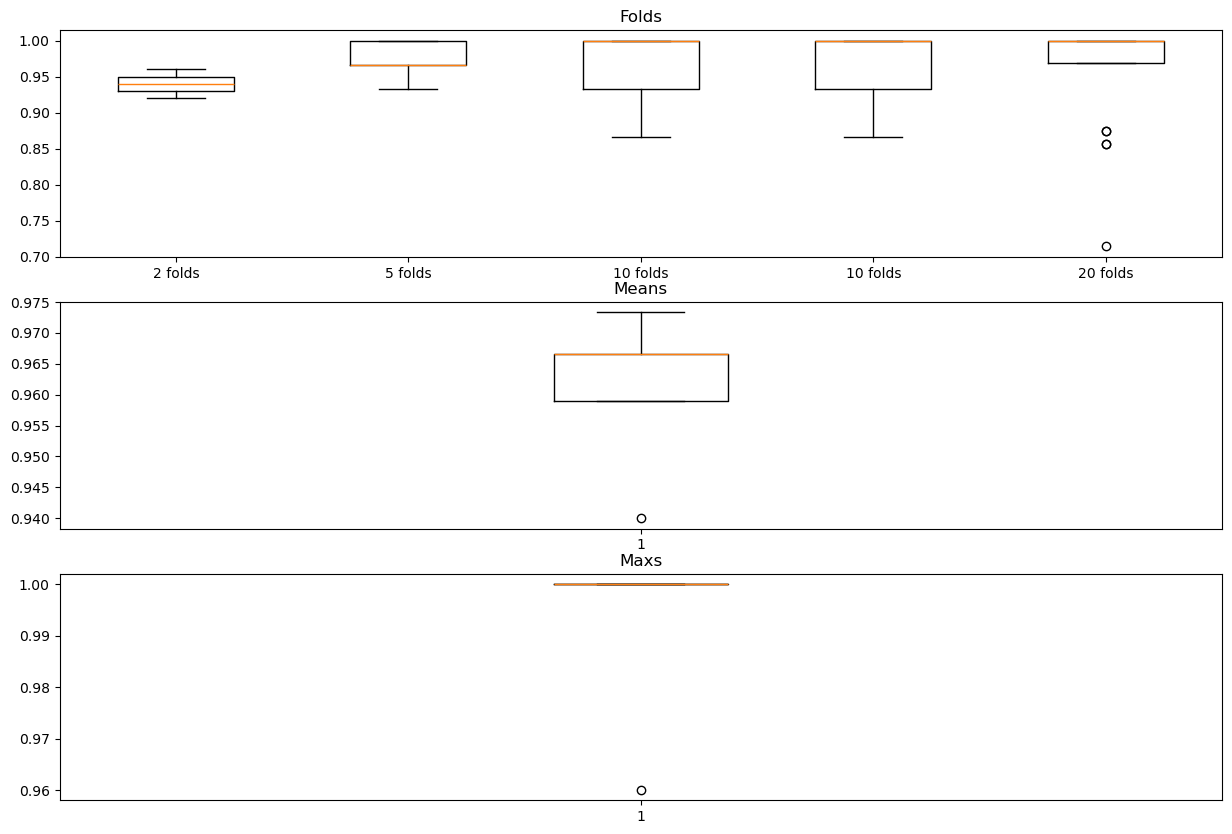

In [191]:
iris.make_boxplot_for_cross_val()

In [192]:
iris.test_knn()

100%|██████████| 5/5 [00:00<00:00, 56.75it/s]


,accuracy,precision,recall,f1
6,1.000000,1.000000,1.000000,1.000000
10,1.000000,1.000000,1.000000,1.000000
1,0.966667,0.969697,0.966667,0.966583
2,0.966667,0.969697,0.966667,0.966583
3,0.966667,0.969697,0.966667,0.966583
4,0.966667,0.969697,0.966667,0.966583
5,0.966667,0.969697,0.966667,0.966583
7,0.966667,0.969697,0.966667,0.966583
8,0.966667,0.969697,0.966667,0.966583
9,0.966667,0.969697,0.966667,0.966583


,accuracy,precision,recall,f1
1/x^2,1.000000,1.000000,1.000000,1.000000
uniform,0.966667,0.969697,0.966667,0.966583
distance,0.966667,0.969697,0.966667,0.966583
1/x,0.966667,0.969697,0.966667,0.966583


,accuracy,precision,recall,f1
chebyshev,1.000000,1.000000,1.000000,1.000000
minkowski,0.966667,0.969697,0.966667,0.966583
euclidean,0.966667,0.969697,0.966667,0.966583
mahalanobis,0.966667,0.969697,0.966667,0.966583
manhattan,0.933333,0.933333,0.933333,0.933333


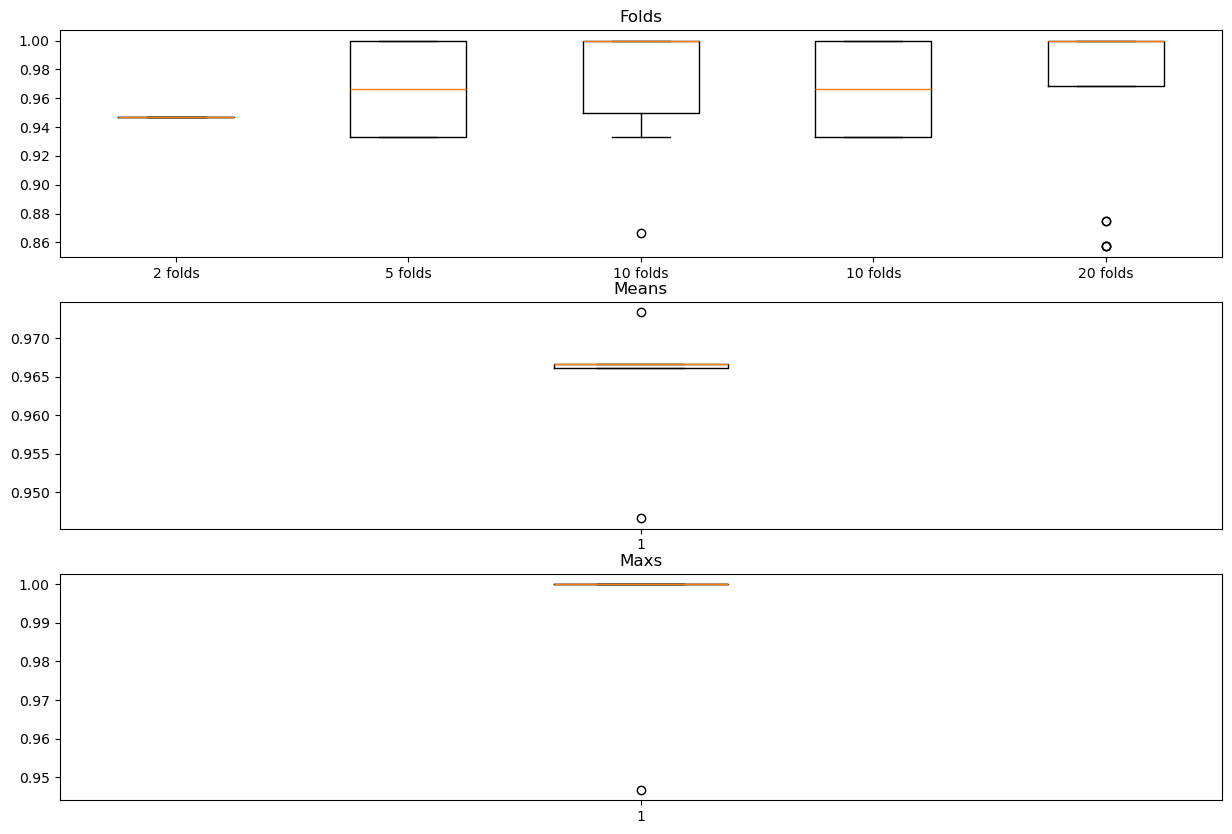

In [193]:
iris.make_boxplot_for_cross_val(stratified=True)

# WINE

In [194]:
wine = WIRINES(load_wine())
wine.make_simple_knn()

,0,1,2
0,12,0,0
1,1,10,3
2,1,3,6


{'accuracy': 0.7777777777777778,
 'precision': 0.7700447700447701,
 'recall': 0.7777777777777778,
 'f1': 0.771196747804935}

In [195]:
wine.make_cross_validation()

In [196]:
wine.make_stratified_cross_validation()

([0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.7428571428571429,
  0.6571428571428571],
 0.6799999999999999,
 0.7429)

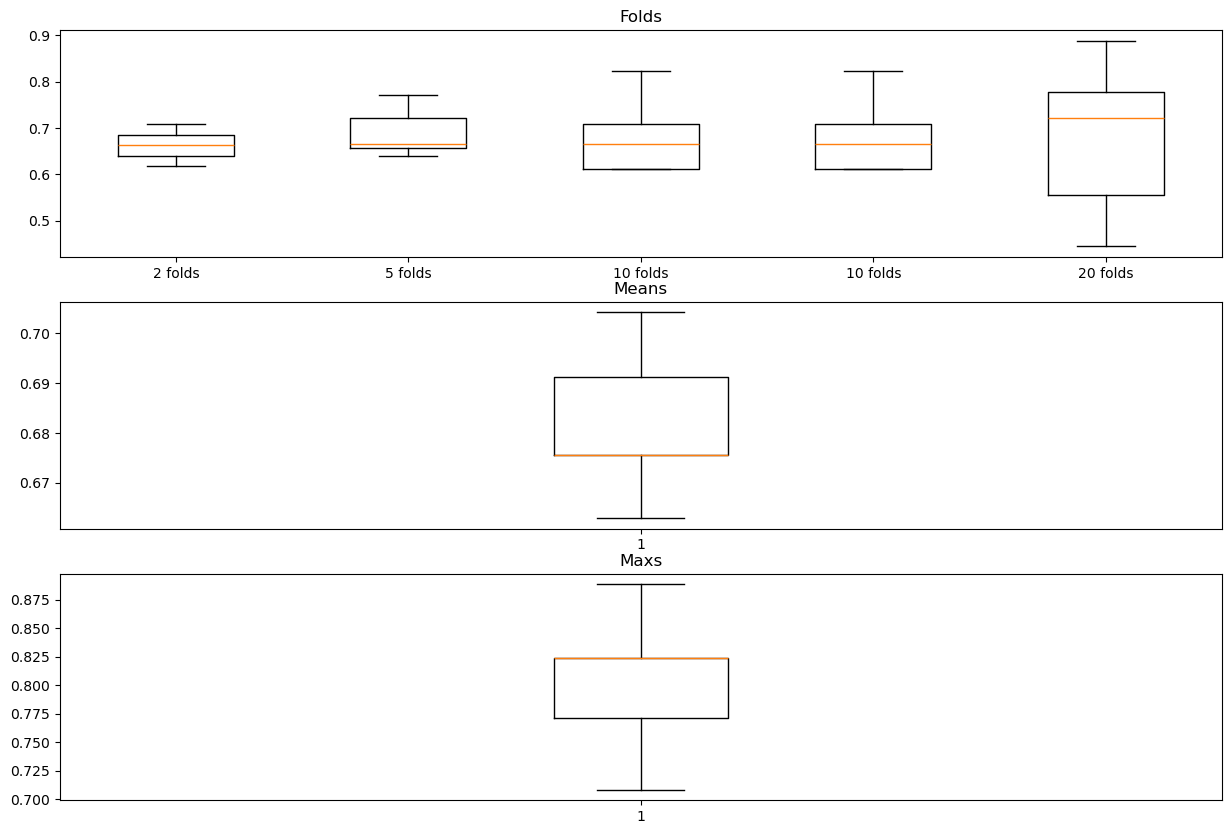

In [197]:
wine.make_boxplot_for_cross_val()

In [198]:
wine.test_knn()

100%|██████████| 5/5 [00:00<00:00, 17.01it/s]


,accuracy,precision,recall,f1
1,0.833333,0.850000,0.833333,0.829058
2,0.805556,0.801282,0.805556,0.802510
13,0.777778,0.791667,0.777778,0.781469
9,0.777778,0.780664,0.777778,0.772877
5,0.777778,0.770045,0.777778,0.771197
15,0.750000,0.773310,0.750000,0.754638
3,0.750000,0.752558,0.750000,0.745657
7,0.750000,0.758862,0.750000,0.743719
4,0.750000,0.737103,0.750000,0.739791
12,0.722222,0.755556,0.722222,0.726852


,accuracy,precision,recall,f1
1/x^2,0.805556,0.811059,0.805556,0.802020
distance,0.777778,0.776127,0.777778,0.774416
1/x,0.777778,0.776127,0.777778,0.774416
uniform,0.777778,0.770045,0.777778,0.771197


,accuracy,precision,recall,f1
manhattan,0.888889,0.901876,0.888889,0.888010
minkowski,0.777778,0.770045,0.777778,0.771197
euclidean,0.777778,0.770045,0.777778,0.771197
chebyshev,0.750000,0.758862,0.750000,0.743719
mahalanobis,0.750000,0.758862,0.750000,0.743719


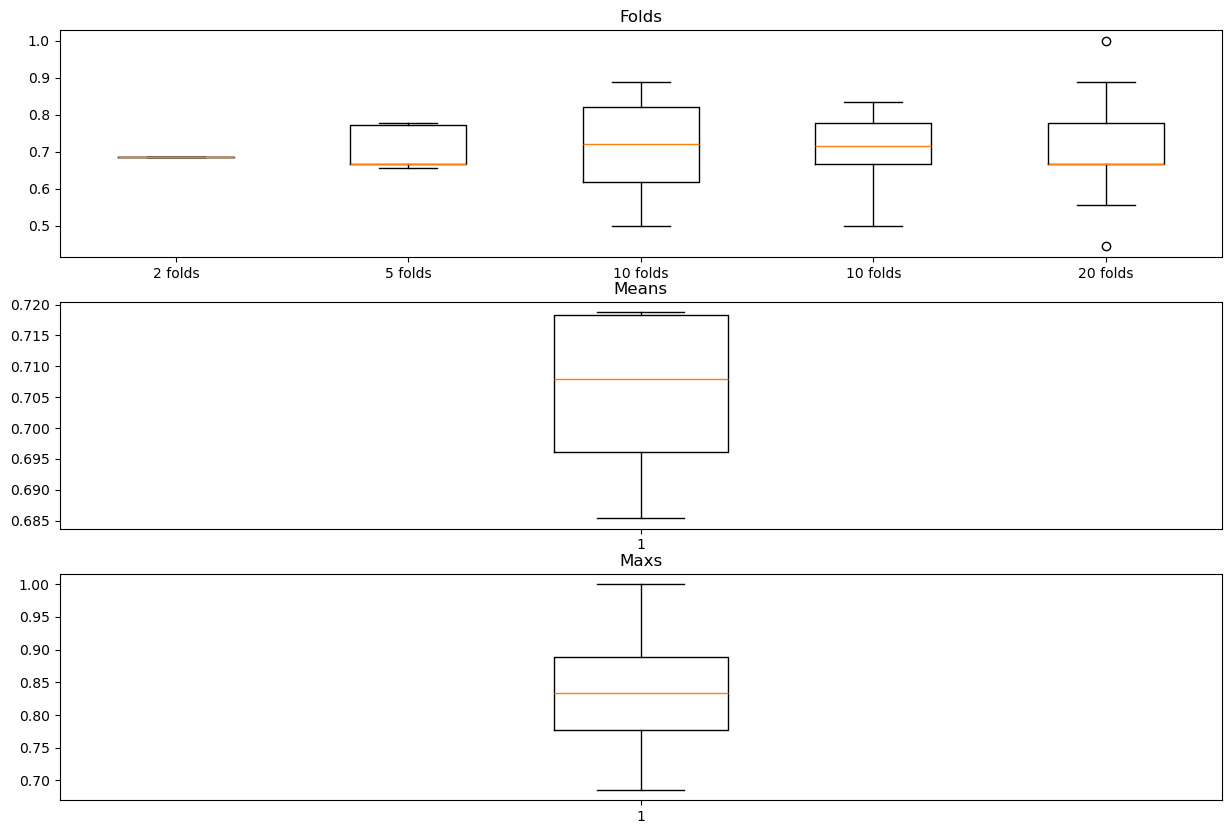

In [199]:
wine.make_boxplot_for_cross_val(stratified=True)

# PCB

In [207]:
year = 1
bankdata = BankData(fr"C:\Users\krzys\Sztuczna Inteligencja\Semestr 1\ML\data\polish+companies+bankruptcy+data/{year}year.arff")
pcb = PCB(bankdata)
pcb.load_and_transform()
pcb.make_simple_knn()

,0,1
0,1081,1
1,43,0


{'accuracy': 0.9608888888888889, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

In [208]:
pcb.make_cross_validation()

(array([0.        , 0.02941176, 0.        , 0.02857143, 0.        ]),
 0.011596638655462186,
 0.0294)

In [209]:
pcb.make_stratified_cross_validation()

([0.0, 0.0, 0.0, 0.0, 0.0], 0.0, 0.0)

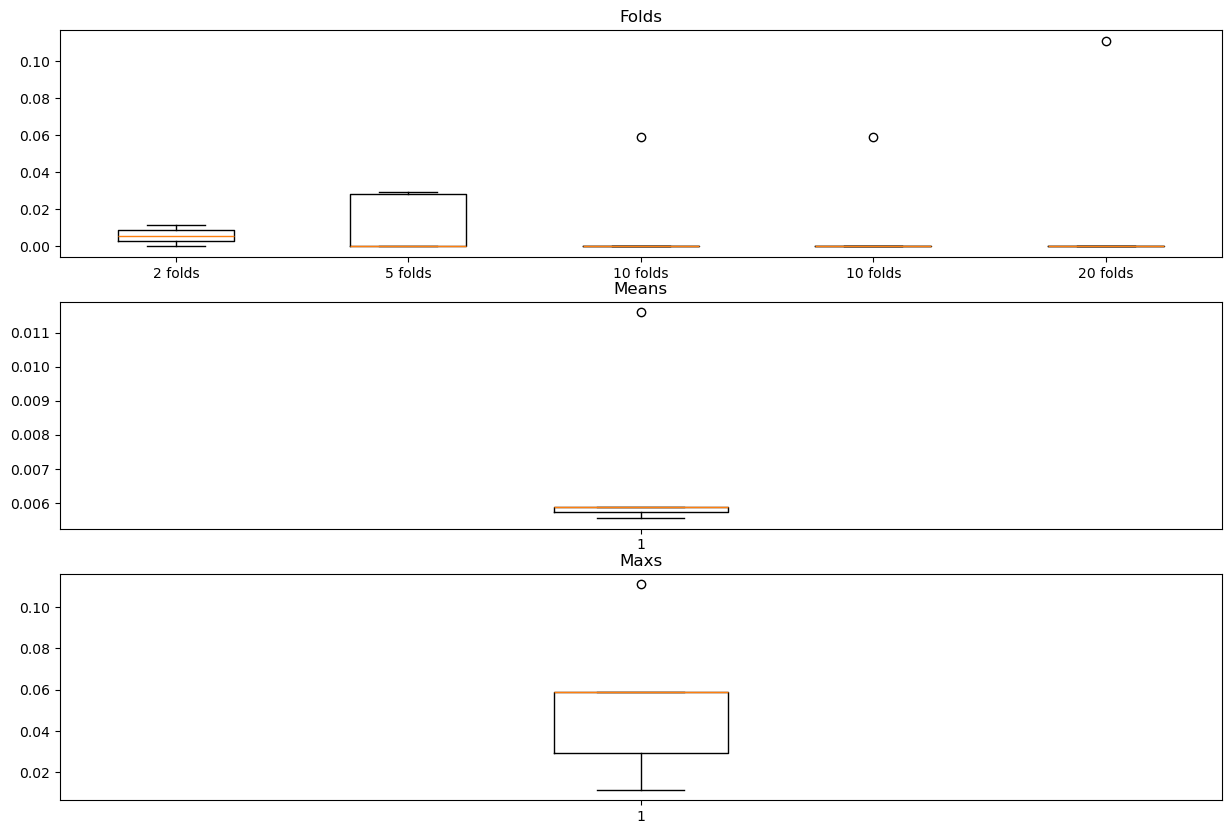

In [210]:
pcb.make_boxplot_for_cross_val()

In [211]:
pcb.test_knn()

 13%|█▎        | 2/15 [00:00<00:01, 11.49it/s]c:\Users\krzys\anaconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|████      | 6/15 [00:00<00:00, 10.78it/s]c:\Users\krzys\anaconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 53%|█████▎    | 8/15 [00:00<00:00, 11.06it/s]c:\Users\krzys\anaconda3\envs\ML\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter t

,accuracy,precision,recall,f1
1,0.926222,0.065217,0.069767,0.067416
4,0.961778,0.000000,0.000000,0.000000
8,0.961778,0.000000,0.000000,0.000000
9,0.961778,0.000000,0.000000,0.000000
10,0.961778,0.000000,0.000000,0.000000
11,0.961778,0.000000,0.000000,0.000000
12,0.961778,0.000000,0.000000,0.000000
13,0.961778,0.000000,0.000000,0.000000
14,0.961778,0.000000,0.000000,0.000000
15,0.961778,0.000000,0.000000,0.000000


,accuracy,precision,recall,f1
uniform,0.960889,0.0,0.0,0.0
distance,0.960000,0.0,0.0,0.0
1/x,0.960000,0.0,0.0,0.0
1/x^2,0.953778,0.0,0.0,0.0


,accuracy,precision,recall,f1
minkowski,0.960889,0.0,0.0,0.0
euclidean,0.960889,0.0,0.0,0.0
manhattan,0.959111,0.0,0.0,0.0
chebyshev,0.959111,0.0,0.0,0.0


In [212]:
pcb.make_stratified_cross_validation()

([0.0, 0.0, 0.02857142857142857, 0.0, 0.0], 0.005714285714285714, 0.0286)

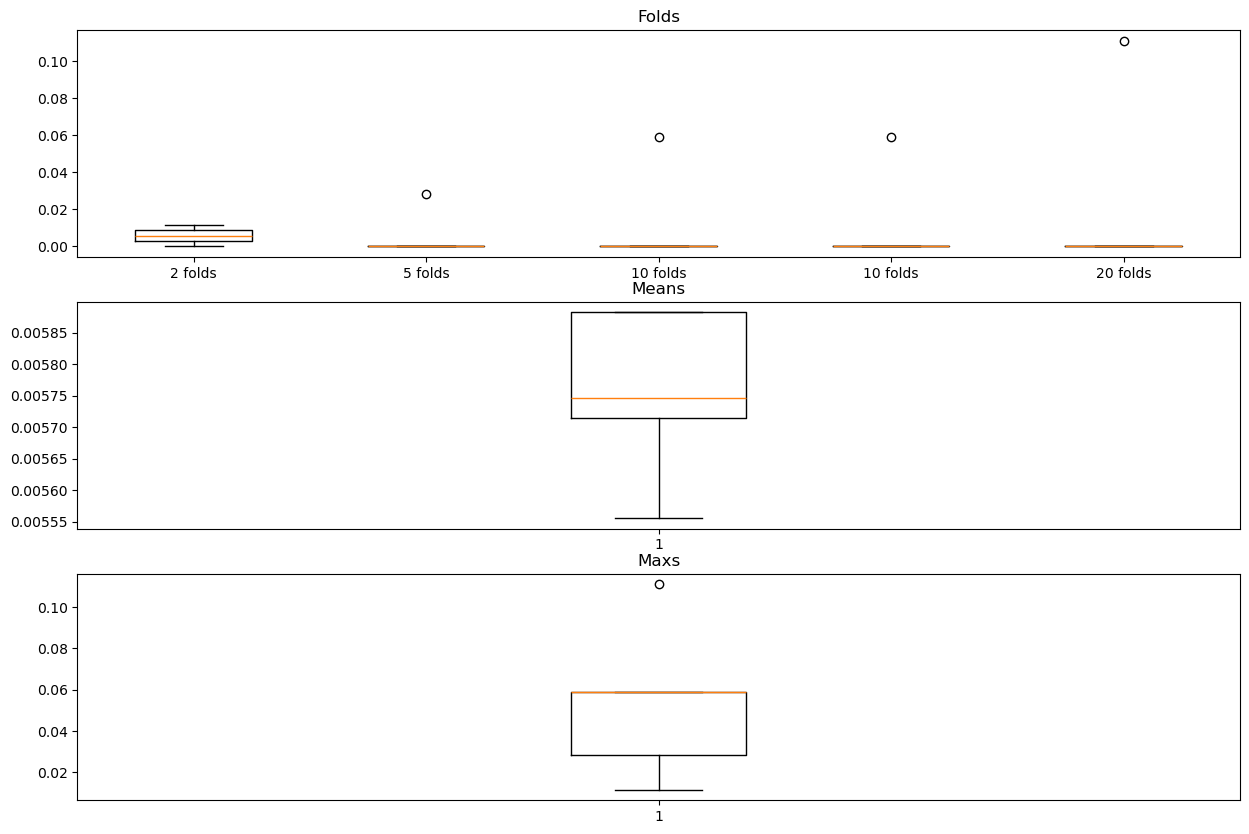

In [213]:
pcb.make_boxplot_for_cross_val(stratified=True)